In [8]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor, export_graphviz
from sklearn.metrics import accuracy_score, mean_squared_error, silhouette_score
from sklearn import tree
import graphviz
import os
ds = pd.read_csv('custom_trash_dataset.csv', sep=',')
# Convert to datetime if not already
ds['Time'] = pd.to_datetime(ds['Time'])

# Keep only the time part (as string in HH:MM:SS format)
ds['Time'] = ds['Time'].dt.time

In [9]:
ds.head()

,Id,Time,TrashType,Location,Confidence,Temperature
0,5dd033ef-2111-4cc5-b7d5-1784068cef88,16:15:00,cardboard,"Haagse Markt, Breda",0.64,25.5
1,823412d8-ecf2-49b3-b748-deb27c8adafc,11:45:00,glass bottle,"Westerpark, Breda",0.76,21.7
2,d58b9f40-ae77-4d8a-b44f-ce0256869b58,22:00:00,plastic bag,"Hoge Vuchtstraat, Breda",0.30,13.2
3,1577e057-5037-4522-91e4-594b7b108b24,11:15:00,battery,"Nieuwe Ginnekenstraat, Breda",0.81,25.1
4,265af0b1-5131-4b48-a2a3-b16f4a2ddfcc,20:45:00,drink carton,Centraal Station Breda,0.44,16.7


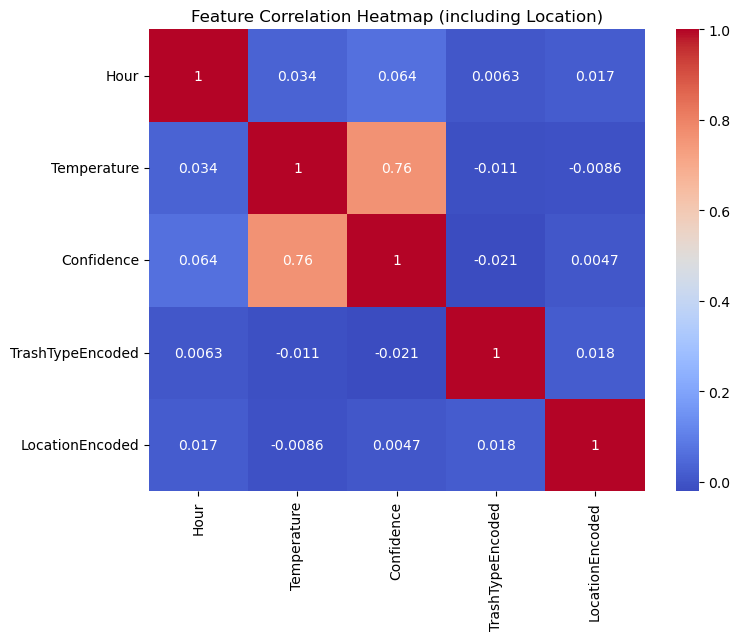

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Reload and parse time
ds = pd.read_csv('custom_trash_dataset.csv')
ds['Time'] = pd.to_datetime(ds['Time'])

# Extract hour from time
ds['Hour'] = ds['Time'].dt.hour

# Encode Location and TrashType as numeric values
ds['LocationEncoded'] = LabelEncoder().fit_transform(ds['Location'])
ds['TrashTypeEncoded'] = LabelEncoder().fit_transform(ds['TrashType'])

# Select relevant numeric features
features = ['Hour', 'Temperature', 'Confidence', 'TrashTypeEncoded', 'LocationEncoded']
corr = ds[features].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap (including Location)')
plt.show()

In [15]:
features = ['Time', 'Temperature', "TrashType"] #add features per iteration such as 'body_mass_g'
X = ds[features]
y = ds['Location']

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Step 1: Handle datetime columns
datetime_cols = X_train.select_dtypes(include=['datetime64']).columns
for col in datetime_cols:
    X_train[col + '_year'] = X_train[col].dt.year
    X_train[col + '_month'] = X_train[col].dt.month
    X_train[col + '_day'] = X_train[col].dt.day
    X_train.drop(columns=col, inplace=True)

# Step 2: Handle categorical (object/string) columns
categorical_cols = X_train.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    label_encoders[col] = le  # Save encoder if needed for X_test or inverse_transform

# Step 3: Fit the model
rf = RandomForestClassifier(criterion='entropy', n_estimators=5, max_depth=3)
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=3, n_estimators=5)

In [20]:
pip install fpdf

Note: you may need to restart the kernel to use updated packages.


In [21]:
from sklearn import tree
import graphviz
from fpdf import FPDF

def plot_tree_classification(model, features, class_names, output_file='random_forest'):  
    if isinstance(model, RandomForestClassifier):
        pdf = FPDF()

        for i, tree_model in enumerate(model.estimators_):
            dot_data = tree.export_graphviz(tree_model, out_file=None, 
                                  feature_names=features,  
                                  class_names=class_names,  
                                  filled=True, rounded=True,  
                                  special_characters=True)  

            # Turn into graph using graphviz
            graph = graphviz.Source(dot_data)  

            # Save as PNG for embedding in PDF
            image_file = f"{output_file}_tree_{i+1}.png"
            graph.render(filename=image_file, format='png')

            # Add each tree image to PDF
            pdf.add_page()
            pdf.image(image_file + '.png', x=10, y=10, w=180)

        # Save the complete PDF
        pdf_output_file = f"{output_file}.pdf"
        pdf.output(pdf_output_file)

        print(f"All trees saved in {pdf_output_file}.")

    else:
        raise ValueError("The model is not a RandomForestClassifier.")                                
    
    return graph

All trees saved in random_forest.pdf.


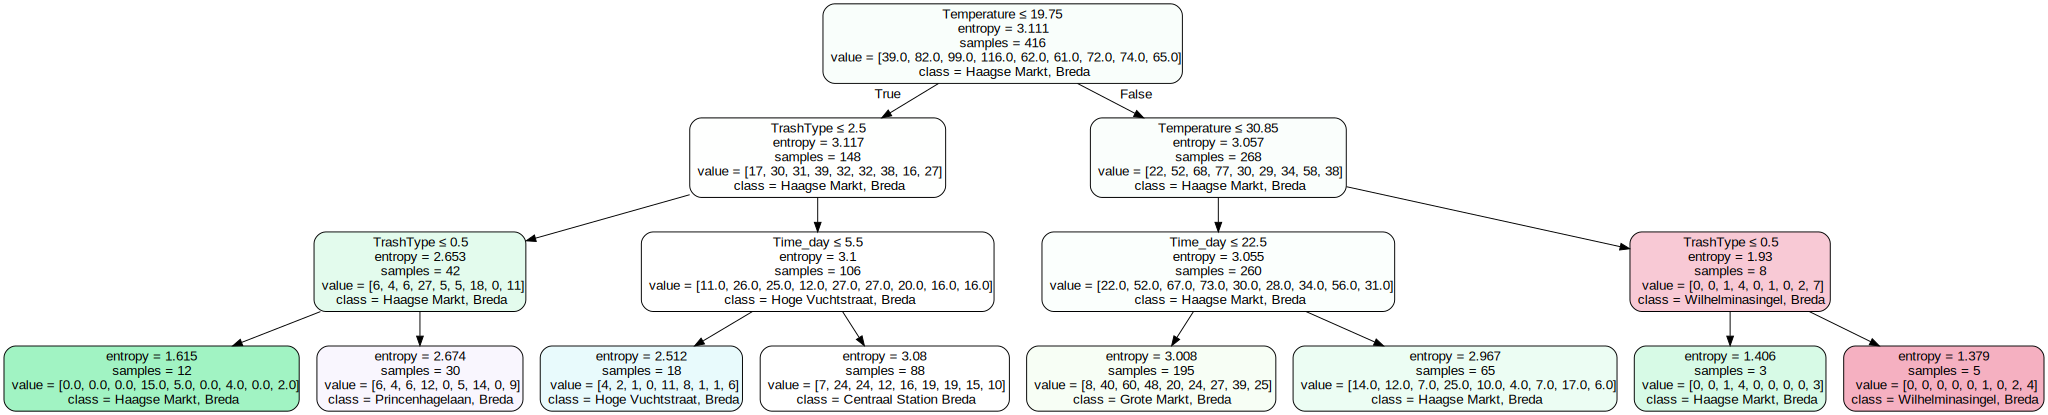

In [23]:
feature_names = X_train.columns
class_names = np.sort(np.unique(y)).astype(str)
plot_tree_classification(rf, feature_names, class_names)

In [24]:
def calculate_accuracy(predictions, actuals):
    if(len(predictions) != len(actuals)):
        raise Exception("The amount of predictions did not equal the amount of actuals")
    
    return (predictions == actuals).sum() / len(actuals)

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Step 1: Handle datetime columns
datetime_cols = X_train.select_dtypes(include=['datetime64']).columns

for col in datetime_cols:
    for df in [X_train, X_test]:
        if col in df.columns and np.issubdtype(df[col].dtype, np.datetime64):
            df.loc[:, col + '_year'] = df[col].dt.year
            df.loc[:, col + '_month'] = df[col].dt.month
            df.loc[:, col + '_day'] = df[col].dt.day
            df.drop(columns=col, inplace=True)

# Step 2: Handle categorical columns (robust version)
all_categorical_cols = list(set(X_train.select_dtypes(include=['object']).columns)
                            | set(X_test.select_dtypes(include=['object']).columns))

label_encoders = {}

for col in all_categorical_cols:
    le = LabelEncoder()
    if col in X_train.columns:
        X_train.loc[:, col] = le.fit_transform(X_train[col])
    if col in X_test.columns:
        X_test.loc[:, col] = X_test[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
    label_encoders[col] = le

# Step 3: Align columns
common_cols = X_train.columns.intersection(X_test.columns)
X_train = X_train[common_cols]
X_test = X_test[common_cols]

# Step 4: Train the model with more complexity
rf = RandomForestClassifier(criterion='entropy', n_estimators=100, max_depth=None, random_state=42)
rf.fit(X_train, y_train)

# Step 5: Make predictions
predictionsOnTrainset = rf.predict(X_train)
predictionsOnTestset = rf.predict(X_test)

# Step 6: Calculate accuracy
def calculate_accuracy(predictions, actual):
    return np.mean(predictions == actual)

accuracyTrain = calculate_accuracy(predictionsOnTrainset, y_train)
accuracyTest = calculate_accuracy(predictionsOnTestset, y_test)

print("Accuracy on training set:", accuracyTrain)
print("Accuracy on test set:", accuracyTest)

Accuracy on training set: 0.8686567164179104
Accuracy on test set: 0.11818181818181818


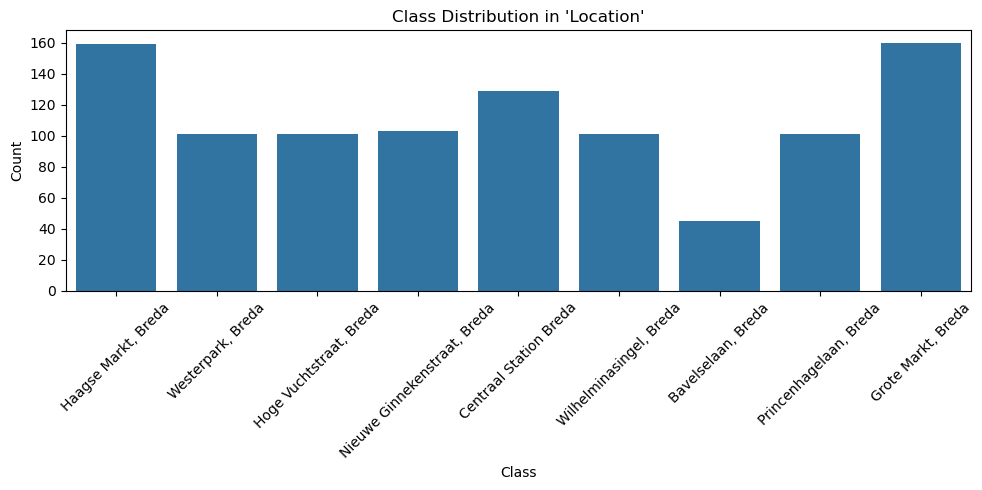

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
ds = pd.read_csv('custom_trash_dataset.csv')

# Check class distribution in 'Location' column
plt.figure(figsize=(10, 5))
sns.countplot(x=ds['Location'])
plt.title("Class Distribution in 'Location'")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import numpy as np

# Load the dataset
ds = pd.read_csv('custom_trash_dataset.csv')

# Convert 'Time' to datetime and extract hour
ds['Time'] = pd.to_datetime(ds['Time'])
ds['Hour'] = ds['Time'].dt.hour

# Encode categorical features
ds['LocationEncoded'] = LabelEncoder().fit_transform(ds['Location'])
ds['TrashTypeEncoded'] = LabelEncoder().fit_transform(ds['TrashType'])

# Select features and target
features = ['Hour', 'Temperature', 'Confidence', 'TrashTypeEncoded', 'LocationEncoded']
X = ds[features]
y = ds['LocationEncoded']

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train the model with class_weight='balanced'
rf = RandomForestClassifier(criterion='entropy', n_estimators=100, max_depth=5, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

# Make predictions
predictionsOnTrainset = rf.predict(X_train)
predictionsOnTestset = rf.predict(X_test)

# Calculate accuracy
def calculate_accuracy(predictions, actual):
    return np.mean(predictions == actual)

accuracyTrain = calculate_accuracy(predictionsOnTrainset, y_train)
accuracyTest = calculate_accuracy(predictionsOnTestset, y_test)

print("Accuracy on training set:", accuracyTrain)
print("Accuracy on test set:", accuracyTest)


Accuracy on training set: 1.0
Accuracy on test set: 1.0


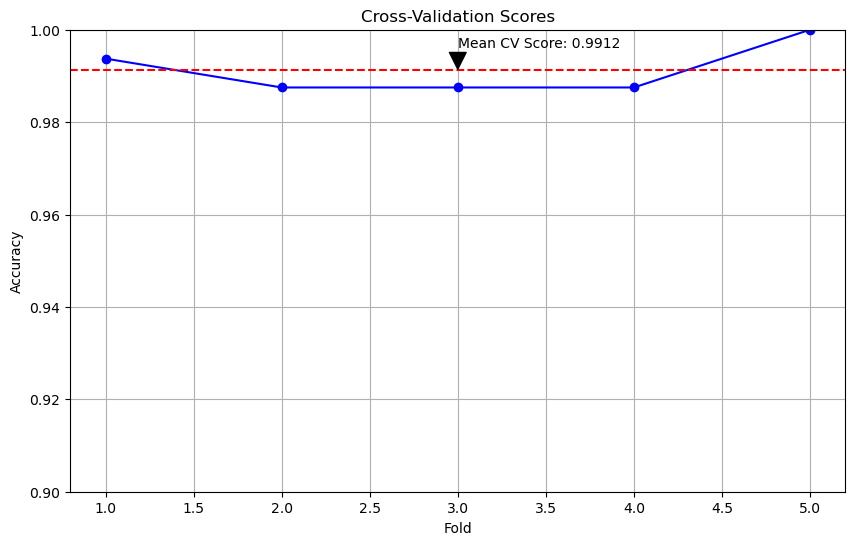

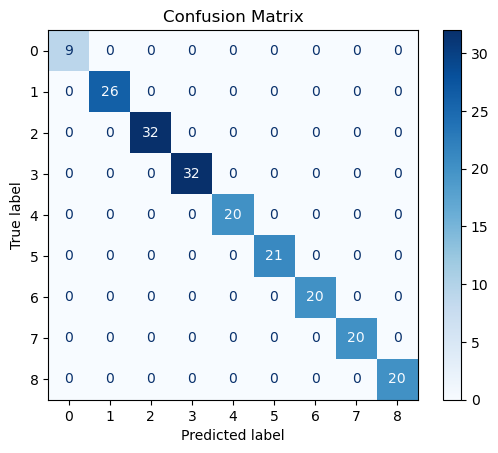

Cross-Validation Scores: [0.99375 0.9875  0.9875  0.9875  1.     ]
Mean CV Score: 0.99125
Accuracy on training set: 1.0
Accuracy on test set: 1.0


In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Load the dataset
ds = pd.read_csv('custom_trash_dataset.csv')

# Convert 'Time' to datetime and extract hour
ds['Time'] = pd.to_datetime(ds['Time'])
ds['Hour'] = ds['Time'].dt.hour

# Encode categorical features
ds['LocationEncoded'] = LabelEncoder().fit_transform(ds['Location'])
ds['TrashTypeEncoded'] = LabelEncoder().fit_transform(ds['TrashType'])

# Select features and target
features = ['Hour', 'Temperature', 'Confidence', 'TrashTypeEncoded', 'LocationEncoded']
X = ds[features]
y = ds['LocationEncoded']

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train the model with class_weight='balanced'
rf = RandomForestClassifier(criterion='entropy', n_estimators=100, max_depth=None, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

# Cross-validation scores
cv_scores = cross_val_score(rf, X_train, y_train, cv=5)
mean_cv_score = cv_scores.mean()

# Make predictions
predictionsOnTrainset = rf.predict(X_train)
predictionsOnTestset = rf.predict(X_test)

# Calculate accuracy
def calculate_accuracy(predictions, actual):
    return np.mean(predictions == actual)

accuracyTrain = calculate_accuracy(predictionsOnTrainset, y_train)
accuracyTest = calculate_accuracy(predictionsOnTestset, y_test)

# Plot cross-validation scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), cv_scores, marker='o', linestyle='-', color='b')
plt.axhline(y=mean_cv_score, color='r', linestyle='--')
plt.title('Cross-Validation Scores')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim(0.9, 1.0)
plt.grid(True)
plt.annotate(f'Mean CV Score: {mean_cv_score:.4f}', xy=(3, mean_cv_score), xytext=(3, mean_cv_score + 0.005),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

# Plot confusion matrix
cm = confusion_matrix(y_test, predictionsOnTestset)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print results
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", mean_cv_score)
print("Accuracy on training set:", accuracyTrain)
print("Accuracy on test set:", accuracyTest)

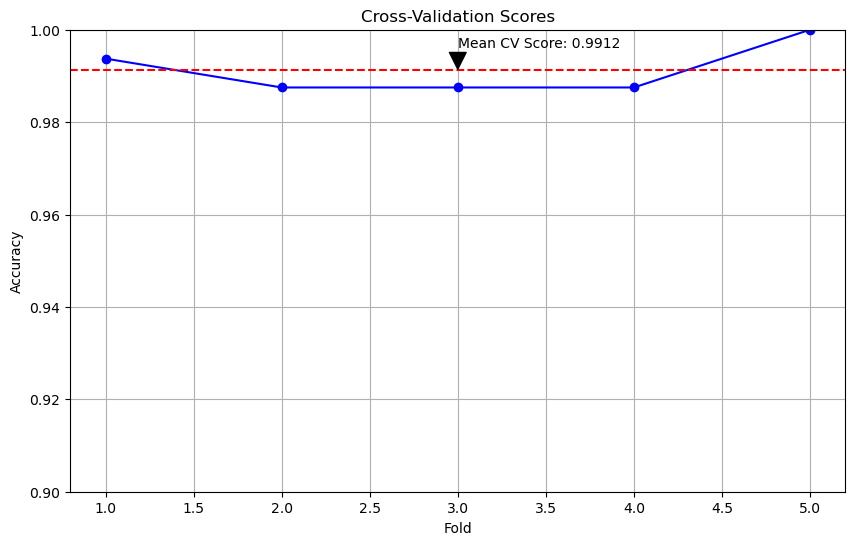

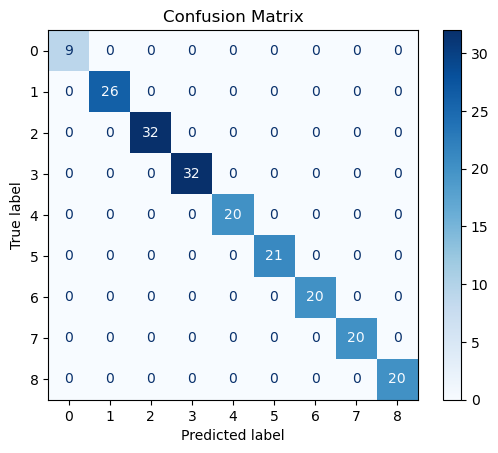

Cross-Validation Scores: [0.99375 0.9875  0.9875  0.9875  1.     ]
Mean CV Score: 0.99125
Accuracy on training set: 1.0
Accuracy on test set: 1.0


In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Load the dataset
ds = pd.read_csv('custom_trash_dataset.csv')

# Convert 'Time' to datetime and extract hour
ds['Time'] = pd.to_datetime(ds['Time'])
ds['Hour'] = ds['Time'].dt.hour

# Encode categorical features
ds['LocationEncoded'] = LabelEncoder().fit_transform(ds['Location'])
ds['TrashTypeEncoded'] = LabelEncoder().fit_transform(ds['TrashType'])

# Select features and target
features = ['Hour', 'Temperature', 'Confidence', 'TrashTypeEncoded', 'LocationEncoded']
X = ds[features]
y = ds['LocationEncoded']

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train the model with class_weight='balanced'
rf = RandomForestClassifier(criterion='entropy', n_estimators=100, max_depth=None, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

# Cross-validation scores
cv_scores = cross_val_score(rf, X_train, y_train, cv=5)
mean_cv_score = cv_scores.mean()

# Make predictions
predictionsOnTrainset = rf.predict(X_train)
predictionsOnTestset = rf.predict(X_test)

# Calculate accuracy
def calculate_accuracy(predictions, actual):
    return np.mean(predictions == actual)

accuracyTrain = calculate_accuracy(predictionsOnTrainset, y_train)
accuracyTest = calculate_accuracy(predictionsOnTestset, y_test)

# Plot cross-validation scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), cv_scores, marker='o', linestyle='-', color='b')
plt.axhline(y=mean_cv_score, color='r', linestyle='--')
plt.title('Cross-Validation Scores')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim(0.9, 1.0)
plt.grid(True)
plt.annotate(f'Mean CV Score: {mean_cv_score:.4f}', xy=(3, mean_cv_score), xytext=(3, mean_cv_score + 0.005),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

# Plot confusion matrix
cm = confusion_matrix(y_test, predictionsOnTestset)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print results
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", mean_cv_score)
print("Accuracy on training set:", accuracyTrain)
print("Accuracy on test set:", accuracyTest)